# DSCI 572 lecture 6

- NN classification, SGD, hyperparameters and what they mean (minibatches, momentum, data preprocessing (e.g. whitening), regularization including dropout, ReLUs, initialization) classification	
- deep learning software

In [2]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline


Vocabulary:

- softmax
- one-hot encoding
- stochastic gradient descent
- minibatches
- dropout
- weight decay
- momentum

Last time: 

- intro to **artificial neural networks** a.k.a. neural networks a.k.a. neural nets
- NN is a family of functions and defined by a recurrence relation
- each layer is a matrix multiplication followed by an elementwise nonlinearity (activation function)
- can represent complex functions
- we ended with the digit classification example: but how do we do classification with neural nets?

### classification

- To use a neural net for classification, we take advantage of the fact that the output doesn't have to be 1-dimensional ($C>1$)
- For example, with the digits there are $10$ classes, so we set the size of the last layer to $C=10$ and use a _one-hot encoding_ for the data
- Each output unit corresponds to one of the classes. 
- It would be nice if each value could represent a _class probability_. We can then make a prediction by taking the largest of these (like with naive Bayes).
  - But the outputs maybe be positive or negative and certainly don't add up to 1
  - We can make them positive by taking the $\exp$ of each one
  - We can then normalize to get them to sum to 1
  - This is called the _softmax_ function: $\frac{\exp(z_j)}{\sum_j \exp(z_j)} $
  
  - (aside) It has this name because it's a soft version of the maximum. Imagine $\frac{\exp(\alpha z_j)}{\sum_j \exp(\alpha z_j)} $ where $\alpha\rightarrow \infty$. Then the largest one would dominate and so we'd be taking the maximum.
- We can then use a loss function like _log probability_ ("logprob"):

$$\mathcal{L}\left(\{W^{(l)}\}\right)= \frac{1}{N}\sum_{i=0}^N \log\left( x^{(L)}_{i y_i} \right) $$

There is a lot going on here. Let's unpack it...

- we are summing over examples as before
- seen the $\log$ before with logistic regression... can interpret as a product of probabilities if examples are iid
- $x^{(L)}$ is the activations at the last layer
- $x^{(L)}_i$ is the activation at the last layer when the input is the $i$th training example (this is the "output" for that "input")
- $y_i$ is the true class label for the $i$th training example
- $x^{(L)}_{i y_i}$ is the particular output unit (out of $C$ total units) corresponing to the _true_ label, after softmax
  - we interpret this as a probability
  - if this were equal to 1 then it means we were perfectly confident in the correct answer
  - if this were equal to 0 it means we were totally wrong
  - we want this to be as high as possible because we're going to predict the largest value

Note: there are other loss functions aside from logprob like [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). 
 - Unlike logprob, cross entropy involves all the probabilities, not just the one corresponding to the true label. 
 - That kind of makes sense... you might want to know how close the second highest option is, for example.

Another important note: we might care most about classification accuracy, but this is not differentiable. That's why we need these loss functions. So now we need to distinguish between classification accuracy and our loss, which we didn't need to do before (e.g. with KNN, decision trees). 

Also: you can think of this as a neural network to learn the features followed by _logistic regression_. Indeed, the last layer is exactly logistic regression!

### classification in action

Below: digits example. Key differences for classification:

- the activation function of the **final** layer
- the loss function

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import datasets
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [10]:
digits = datasets.load_digits()
X = digits['data']
y = digits['target']

X /= 255.0
y = np_utils.to_categorical(y, 10) # make it 1-hot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
model = Sequential()
model.add(Dense(500, input_dim=64, init='normal', activation='relu'))
model.add(Dense(500, init='normal', activation='relu'))
model.add(Dense(10, init='normal', activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, nb_epoch=10, verbose=0)




# estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=200, batch_size=5, verbose=0)
# kfold = KFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, X_train, y_train, cv=kfold)
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(model.predict(X_test))

training_loss = model.evaluate(X_train, y_train, verbose=0)
print("Training %s: %.2f" % (model.metrics_names[0], training_loss[0]))
print("Training %s: %.2f" % (model.metrics_names[1], training_loss[1]))

test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Test %s: %.2f" % (model.metrics_names[0], test_loss[0]))
print("Test %s: %.2f" % (model.metrics_names[1], test_loss[1]))

[[  3.77186370e-04   1.82712083e-05   1.88781826e-07 ...,   1.83741218e-08
    3.19440122e-04   3.94855169e-06]
 [  1.55104462e-05   1.72414005e-07   5.11276221e-09 ...,   5.73783791e-06
    2.52580612e-05   1.90695859e-02]
 [  9.61732560e-09   5.35944719e-06   2.56453262e-04 ...,   9.92823516e-07
    5.50063734e-04   1.17586460e-03]
 ..., 
 [  1.14488660e-03   4.89698723e-05   4.28688085e-10 ...,   4.97632209e-06
    4.04713865e-05   7.01335694e-07]
 [  2.34782565e-05   5.23672156e-07   2.25839059e-07 ...,   1.82182384e-06
    2.30992940e-04   7.16379434e-02]
 [  2.83477250e-02   1.99595327e-08   4.01524449e-06 ...,   3.63669201e-08
    1.18815959e-04   1.87289741e-04]]
Training loss: 0.17
Training acc: 0.95
Test loss: 0.21
Test acc: 0.93


### Stochastic gradient descent (SGD)

- The loss function involved a sum over $N$ terms.
- Therefore the gradients involve a sum over $N$ terms. 
- This can be prohibitively slow if $N$ is large. 
- Idea: sample a _subset_ of the data points and only use those terms in the sum.

$$\mathcal{L}(w) = \sum_{n=1}^N \ell_i(w) $$

$$\nabla_w \mathcal{L}(w) = \nabla_w \sum_{n=1}^N \ell_i(w) =\sum_{n=1}^N \nabla_w \ell_i(w) $$

We can switch the order by linearity. So we see the gradient is a sum of per-example gradients.

Let's rescale the loss by a factor of $\frac1N$ (this doesn't change anything). Then we get:

$$\nabla_w \mathcal{L}(w) =\frac1N \sum_{n=1}^N \nabla_w \ell_i(w) $$

This is an _average_ of per-example gradients.

Key idea of SGD: instead of taking an average of these $N$ gradients, just randomly sample one example (or a small "minibatch").


![](SGD.png)

- you don't pick the direction as carefully, but it costs you $N$ times less effort per step!
- the expected value is the true gradient (that's why we needed to add in the $\frac1N$ above)
- the computational expenditure is no longer $\mathcal{O}(N)$
- great at the beginning when most/all examples agree, trickier when you get close to the optimum
  - necessitates decreasing the learning rate over time, or using other tricks
- often we don't use "vanilla" SGD; there are many extensions
  - momentum, RMDprop, Adagrad, Adam, SAG, ...
  - currently, Adam is the favourite
  - see [this blog post](http://sebastianruder.com/optimizing-gradient-descent/) for more info if you're interested
  - main ideas are smoothing out the erratic behaviour of SGD, and adaptively choosing the learning rate
- key hyperparameters: learning rate (if not adaptive), learning rate cooling schedule, minibatch size, method-specific hyperparemeters
- number of iterations becomes number of _epochs_. An epoch is a full pass through the dataset. So if the dataset has $10^5$ examples and your minibatch size is 1000, then an epoch is 100 iterations of stochastic gradient descent.

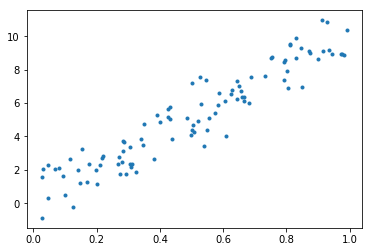

In [3]:
# example for OLS with GD and SGD

# generate random data
N = 100
x = np.random.rand(100)
y = 10*x + np.random.randn(100)

# plot the points
plt.plot(x,y,'.')

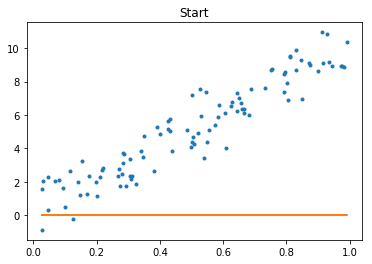

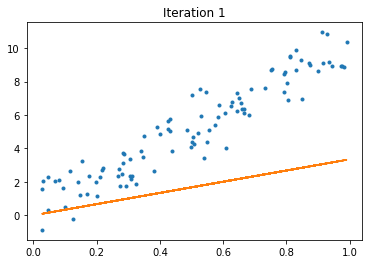

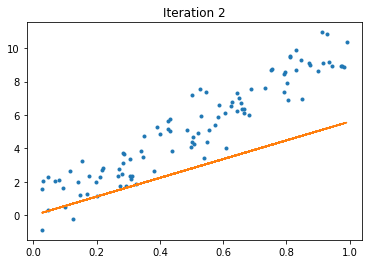

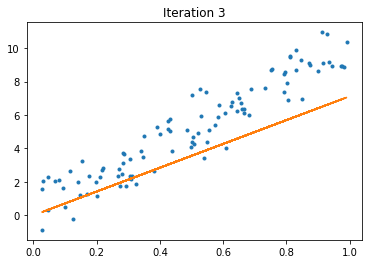

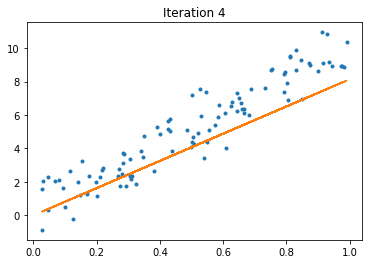

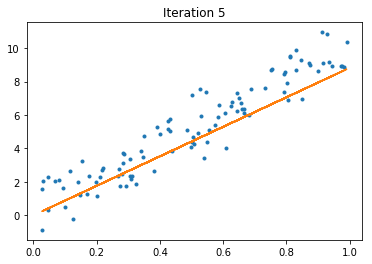

w = 8.827270


In [9]:
# gradient decent

w = 0
alpha = 1
Nsteps = 5

plt.figure()
plt.plot(x,y,'.')
plt.plot(x,w*x)
plt.title("Start")


for t in range(Nsteps):
    dLdw = np.mean(x*(w*x-y))
    w -= alpha*dLdw
    
    plt.figure()
    plt.plot(x,y,'.')
    plt.plot(x,w*x)
    plt.title("Iteration %d" % (t+1))
    plt.show()

print("w = %f" % w)

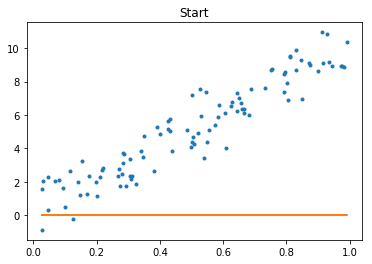

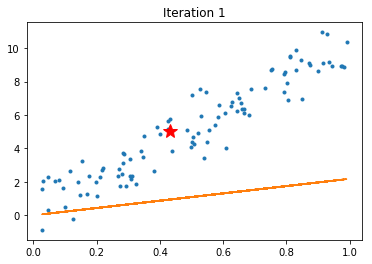

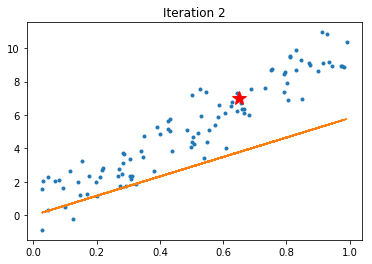

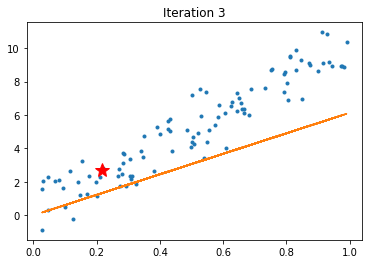

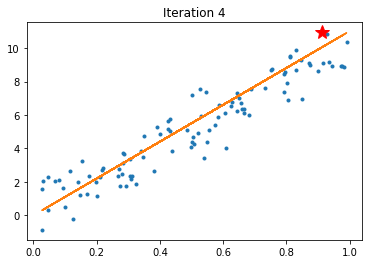

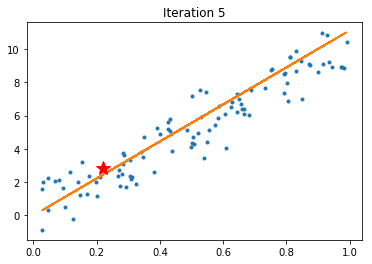

w = 11.119102


In [14]:
# stochastic gradient decent

w = 0
alpha = 1
Nsteps = 5
minibatch_size = 1

# loss = sum (wx-y)^2
plt.figure()
plt.plot(x,y,'.')
plt.plot(x,w*x)
plt.title("Start")

for t in range(Nsteps):
    
    i = np.random.choice(N,size=minibatch_size,replace=False) 

    dLdw = np.mean(x[i]*(w*x[i]-y[i]))
    w -= alpha*dLdw
    
    plt.figure()
    plt.plot(x,y,'.')
    plt.plot(x,w*x)
    plt.plot(x[i],y[i],'*',color='red',markersize=15)
    plt.title("Iteration %d" % (t+1))
    plt.show()

print("w = %f" % w)

### Regularization

- you've discussed regularization in DSCI 573
- neural nets use some standard regularization and some funny ones
- _weight decay_: just a name for L2-regularization on the weights
- weight normalization, set a maximum value for the weights
- dropout: randomly delete (set to 0) your activations
  - this sounds crazy but there's a lot of intuition here
  - preventing co-adaptation
  - has an interpretation as ensembling models with different architectures
    - but without the added computational cost

### Demo: RBF features fitting with dropout

#### generate some random data in 1-d

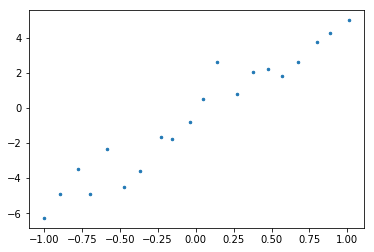

In [16]:
N = 20
X = np.linspace(-1,1,N)+npr.randn(N)*0.01
X=X[:,None]
y = npr.randn(N,1) + X*5

plt.plot(X,y,'.',markersize=5)

#### try fitting with RBF features

[ 11.99529168]
Loss = 0.000000


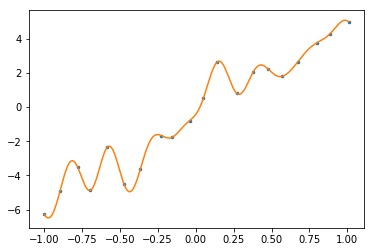

In [17]:
def euclidean_dist_squared(X, Xtest):
    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)

class RBF_features():
    def __init__(self, sigma=1):
        self.sigma=sigma

    def fit(self,Xtrain):
        self.Xtrain = Xtrain
    
    def transform(self, Xtest):
        return np.exp(-0.5*euclidean_dist_squared(Xtest,self.Xtrain)/self.sigma**2)

    
rbf = RBF_features(sigma=0.1)
rbf.fit(X)

grid = np.linspace(min(X),max(X),1000)[:,None]
grid_Z = rbf.transform(grid)

Z = rbf.transform(X)
w = npla.solve(Z.T@Z,Z.T@y)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)



The above model looks like it overfits. We now try to combat this with

#### add L2-regularization

(20, 20)
[ 2.63930213]
Loss = 18.320752


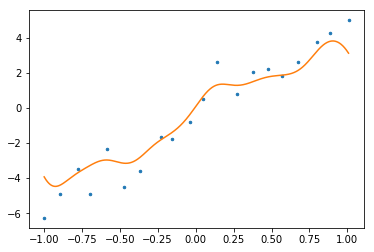

In [19]:
# add regularization
print(Z.shape)
d = Z.shape[1]

reg_strength = 1
w = npla.solve(Z.T @ Z + reg_strength*np.eye(d), Z.T @ y)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)

(above) regularization seems to work

#### re-do unregularized problem, but with gradient descent instead of normal eqn's

[ 11.81066922]
Loss = 0.018115
[[  1.36803003e-07]]


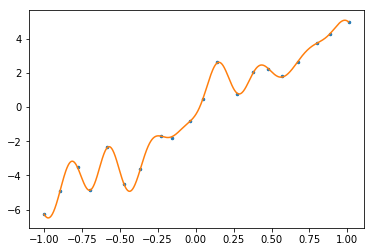

In [23]:
d = Z.shape[1]
w = np.zeros((d,1))
alpha = 1
Nsteps = 10000

reg_strength = 0

ZTZ = Z.T@Z + reg_strength*np.eye(d)

for t in range(Nsteps):
    
    dLdw = (ZTZ@w-Z.T@y)/N
    w -= alpha*dLdw
#     loss = np.sum((Z@w-y)**2)
#     print("Loss = %f" % loss)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)
print(dLdw.T@dLdw)

Above: looks the same as with normal equations, OK good.

#### now we use dropout. At each iteration we randomly select what to drop.

you can drop the activations _or_ the weights

- dropping the weights is more intuitive with respect to the idea of "averaging different architectures"
- the two approaches are basically equivalent. But the implementations are a bit different.
- we'll do both implementations below.

First, dropping the weights

[ 3.70597416]
Loss = 10.046302
[[ 0.42030122]]


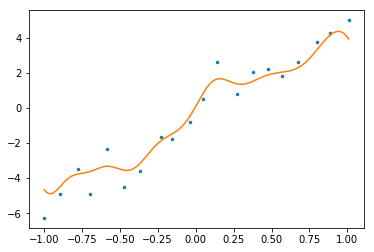

In [30]:
# with dropout 
d = Z.shape[1]
w = np.zeros((d,1))
alpha = 1
Nsteps = 10000
ZTZ = Z.T@Z
dropout_prob = 0.25

for t in range(Nsteps):
    

    mask = np.random.rand(d,1) > dropout_prob
    w_drop = w * mask     # dropping the weights

    dLdw = (ZTZ@w_drop-Z.T@y)/N
    w -= alpha*dLdw*mask
#     loss = np.sum((Z@w-y)**2)
#     print("Loss = %f" % loss)

w = w * (1-dropout_prob) # scale for prediction - this is important

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
# print(w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)
print(dLdw.T@dLdw)

Above: dropout seems to do what we expect! That is great. You can play around with the dropout probability to see how it behaves.

** note the line of code where we scale $w$ at the end **

- we need to "make testing like training" but we want to use all the weights during testing
- so we just scale things down proportionally since we're using more weights than usual

(below) We can also drop the activations instead of the weights, but now we don't precompute $Z^TZ$:

[ 3.5749606]
Loss = 10.650053
[[ 0.02153788]]


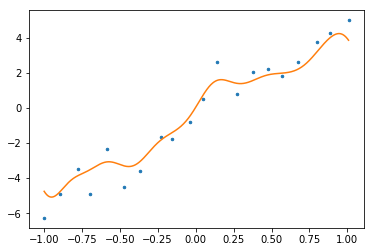

In [26]:
# with dropout 
d = Z.shape[1]
w = np.zeros((d,1))
alpha = 1
Nsteps = 10000
dropout_prob = 0.25

for t in range(Nsteps):
    
    # can dropout the Z's or the w's probably
    mask = np.random.rand(*Z.shape) > dropout_prob
    Z_drop = Z * mask

    dLdw = (Z_drop.T@Z_drop@w-Z_drop.T@y)/N
    w -= alpha*dLdw
#     loss = np.sum((Z@w-y)**2)
#     print("Loss = %f" % loss)

w = w * (1-dropout_prob) # scale for prediction - this is important

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_Z@w)
# print(w)
print(max(abs(w)))
loss = np.sum((Z@w-y)**2)
print("Loss = %f" % loss)
print(dLdw.T@dLdw)

(above) The result is almost identical whether you're dropping the weights or the activations. 

- (bonus) There are some other implementation details. Like we can amplify the weights/activations during training instead of dampening them afterwards. This allows flexibility like sampling different dropout probabilities at different iterations.

### Other forms of regularization

- Early stopping
- Philosophical question: do we craft the perfect optimization problem, and then hand it off to the optimization experts? Or are we stuck with the interplay between ML/generalization and optimization?

### Supplementary (optional) material: NN classification with Autograd

In [4]:
# Adapted from https://github.com/HIPS/autograd/tree/master/examples

"""A multi-layer perceptron for classification of MNIST handwritten digits."""
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.misc import logsumexp
from autograd import grad
from autograd.util import flatten
from autograd.optimizers import adam

from sklearn import datasets
from sklearn.model_selection import train_test_split

def load_mnist():
    digits = datasets.load_digits()
    X = digits['data']
    y = digits['target']
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    X /= 255.0
    y = one_hot(y, 10)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return len(y_train), X_train, y_train, X_test, y_test


def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples,
       one for each layer in the net."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def neural_net_predict(params, inputs):
    """Implements a deep neural network for classification.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns normalized class log-probabilities."""
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = np.tanh(outputs)
    return outputs - logsumexp(outputs, axis=1, keepdims=True)

def l2_norm(params):
    """Computes l2 norm of params by flattening them into a vector."""
    flattened, _ = flatten(params)
    return np.dot(flattened, flattened)

def log_posterior(params, inputs, targets, L2_reg):
    log_prior = -L2_reg * l2_norm(params)
    log_lik = np.sum(neural_net_predict(params, inputs) * targets)
    return log_prior + log_lik

def accuracy(params, inputs, targets):
    target_class    = np.argmax(targets, axis=1)
    predicted_class = np.argmax(neural_net_predict(params, inputs), axis=1)
    return np.mean(predicted_class == target_class)

def main():
    # Model parameters
    layer_sizes = [64, 200, 100, 10] #[784, 200, 100, 10]
    L2_reg = 1.0

    # Training parameters
    param_scale = 0.1
    batch_size = 256
    num_epochs = 100
    step_size = 0.001

    print("Loading training data...")
    N, train_images, train_labels, test_images,  test_labels = load_mnist()

    init_params = init_random_params(param_scale, layer_sizes)

    num_batches = int(np.ceil(len(train_images) / batch_size))
    def batch_indices(iter):
        idx = iter % num_batches
        return slice(idx * batch_size, (idx+1) * batch_size)

    # Define training objective
    def objective(params, iter):
        idx = batch_indices(iter)
        return -log_posterior(params, train_images[idx], train_labels[idx], L2_reg)

    # Get gradient of objective using autograd.
    objective_grad = grad(objective)

    print("     Epoch     |    Train accuracy  |       Test accuracy  ")
    def print_perf(params, iter, gradient):
        if iter % num_batches == 0:
            epoch = iter/num_batches
            if epoch % 10 == 0: # print every 10 epochs
                train_acc = accuracy(params, train_images, train_labels)
                test_acc  = accuracy(params, test_images, test_labels)
                print("{:15}|{:20}|{:20}".format(iter//num_batches, train_acc, test_acc))

    # The optimizers provided can optimize lists, tuples, or dicts of parameters.
    optimized_params = adam(objective_grad, init_params, step_size=step_size,
                            num_iters=num_epochs * num_batches, callback=print_perf)

main()